In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [3]:
mean = 0.
std = 0.
for images, _ in trainloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(trainloader.dataset)
std /= len(trainloader.dataset)

print(mean, std)


mean = 0.
std = 0.
for images, _ in testloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(testloader.dataset)
std /= len(testloader.dataset)

print(mean, std)

tensor([-0.7387]) tensor([0.6030])
tensor([-0.7350]) tensor([0.6077])


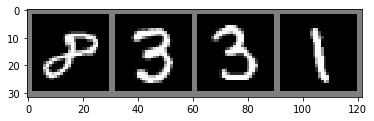

    8     3     3     1


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
#Check if freezing works
#print(list(filter(lambda p: p.requires_grad, net.parameters())))

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #Don't know if you have to have filter
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
#torch.cuda.device_count()
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
numEpoch = 1
start_time = time.time()

for epoch in range(numEpoch):  # loop over the dataset multiple times

    running_loss = 0.0
    size = len(trainloader)
    print(size)
    size = 2000
    running_correct = 0
    running_total = 0
    for i, data in enumerate(trainloader, 0):
        correct = 0
        total = 0
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_total += total
        running_correct += correct

        # print statistics
        running_loss += loss.item()
        if i % size == size-1:    # print every 2000 batch
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / size))
            running_loss = 0.0
            
            print('Train accuracy: %d %%' % (
    100 * running_correct / running_total))
            running_correct = 0
            running_total = 0

print('Finished Training')

print("--- %s seconds ---" % (time.time() - start_time))
print ("--- %s seconds/epoc ---" % ((time.time() - start_time)/numEpoch))

15000
[1,  2000] loss: 1.315
Train accuracy: 55 %
[1,  4000] loss: 0.227
Train accuracy: 92 %
[1,  6000] loss: 0.141
Train accuracy: 95 %
[1,  8000] loss: 0.134
Train accuracy: 95 %
[1, 10000] loss: 0.105
Train accuracy: 96 %
[1, 12000] loss: 0.095
Train accuracy: 97 %
[1, 14000] loss: 0.083
Train accuracy: 97 %
Finished Training
--- 52.725425243377686 seconds ---
--- 52.72552180290222 seconds/epoc ---


In [9]:
PATH = './MNIST.pth'

In [10]:
torch.save(net.state_dict(), PATH)

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
start_time = time.time()

net.to(device)
correct = 0
total = 0

nb_classes = 10
confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print(confusion_matrix.int())

print("--- %s seconds ---" % (time.time() - start_time))
print ("--- %s seconds/test ---" % ((time.time() - start_time)/total))

Accuracy of the network on the test images: 97 %
tensor([[ 976,    1,    1,    0,    0,    0,    0,    2,    0,    0],
        [   0, 1131,    1,    1,    0,    0,    1,    1,    0,    0],
        [  10,    2, 1012,    0,    4,    0,    0,    2,    2,    0],
        [   4,    1,    8,  982,    0,    3,    0,    8,    2,    2],
        [   0,    2,    0,    0,  972,    0,    0,    0,    0,    8],
        [  10,    0,    0,    4,    0,  862,   10,    1,    1,    4],
        [  13,    3,    0,    0,    5,    1,  936,    0,    0,    0],
        [   1,    3,    7,    0,    0,    0,    0, 1011,    1,    5],
        [  18,    2,    4,    2,    5,    0,    4,    3,  926,   10],
        [   6,    3,    0,    4,    6,    2,    0,    6,    0,  982]],
       dtype=torch.int32)
--- 4.727086067199707 seconds ---
--- 0.0004727199077606201 seconds/test ---


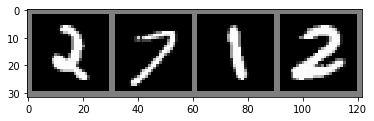

GroundTruth:      2     7     1     2
Predicted:      2     7     1     2


In [13]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=0)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))